In [1]:
import gymnasium as gym
import numpy as np
import os

from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3 import A2C, PPO, TD3

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env

import matplotlib.pyplot as plt




## For making GIFs

In [3]:
import gymnasium as gym
import numpy as np
import imageio

#
folder = "gifs/"

# Make the environment and the initial observation 
env_name = "BipedalWalker-v3"
env = gym.make(env_name)
obs_dim = env.observation_space.shape
act_dim = env.action_space.shape[0]
act_limit = env.action_space.high[0]
observation = env.reset()

# Book-keeping.
num_episodes = 1 # how many gifs to make
ep_return = 0
ep_length = 0
ep_done = 0
ep_observations = []

# For video / GIF.
dur = 0.0001
#width = 250
#height = 200
env = make_vec_env(env_name, n_envs=1)
observation = env.reset()


loadedModel = PPO('MlpPolicy', env, verbose=1)
loadedModel = loadedModel.load("tmp/best_model.zip")



while ep_done < num_episodes:

    rgb_observation = env.get_images()
    #print(rgb_observation)

    #assert obs.shape == (height, width, 3), obs.shape  # height first!
    ep_observations.append(rgb_observation)

    # Take action, step into environment, etc.
    action = loadedModel.predict(observation, deterministic=True)

    (observation, reward, done, _) = env.step(action[0])

    ep_return += reward
    ep_length += 1

    if done:
        # Form GIF. imageio should read from numpy: https://imageio.github.io/
        print(f'Episode {ep_done}, cum. return: {ep_return}, length: {ep_length}.')
        ep_name = folder + f'ep_{env_name}_{str(ep_done).zfill(2)}_dur_{dur}_len_{str(ep_length).zfill(3)}.gif'
        with imageio.get_writer(ep_name, mode='I', duration=dur) as writer:
            for obs_np in ep_observations:
                writer.append_data(obs_np)

        # Reset information.
        observation = env.reset()
        ep_ret = 0
        ep_len = 0
        ep_done += 1
        ep_obs = []

Using cpu device
Episode 0, cum. return: [299.63593], length: 1119.


In [16]:
test_env = make_vec_env(env_name, n_envs=1)

evaluate_policy(model=loadedModel, env=test_env, n_eval_episodes=10)

(299.6771192, 1.203590787942461)

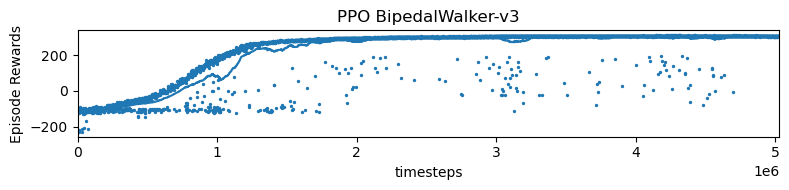

In [8]:
from stable_baselines3.common import results_plotter

log_dir = "best/"
plot_title = "PPO BipedalWalker-v3" 
timesteps = 5e7

# Helper from the library
fig = results_plotter.plot_results(
    [log_dir], None, results_plotter.X_TIMESTEPS, plot_title
)

PPO_Bipedal_1__n_envs=32_n_steps=2048_batch_size=64_gae_lambda=0.9_gamma=0.999_n_epochs=20_ent_coef=0.0_learning_rate=0.0005_clip_range=0.3_.monitor.csv
SUCCESS, in 2510316.0 timesteps


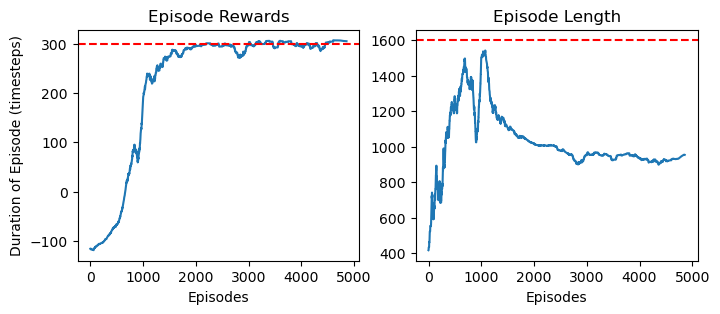

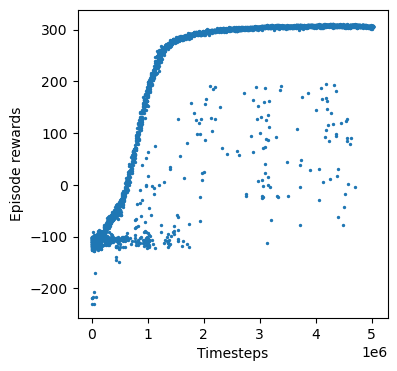

In [42]:
log_dir = "gridsearch/"

for file in os.listdir(log_dir)[1:]:
    log_file_path = os.path.join(log_dir, file)

    rewards = []
    timesteps = []
    with open(log_file_path, "r") as log_file:
        for line in log_file:
            if not line.startswith("#"):  # Skip comment lines
                try:
                    reward = float(line.split(",")[0])  # Extract the reward value
                    time = float(line.split(",")[1])

                    rewards.append(reward)
                    timesteps.append(time)
                except:
                    #print("could not turn to float: ", line.split(",")[0])
                    #print("in file: ", log_file_path )
                    continue
    
    reward_target = 300
    timestep_target = 1600
    window_size = 100
    reward_averages = []
    timestep_averages = []
    i = 0
    reward_average = 0
    timestep_average = 1000000

    SUCCESS = False

    while (i < len(rewards) - window_size + 1):
        reward_average = round(sum(rewards[i : i + window_size]) / window_size, 2)
        timestep_average = round(sum(timesteps[i : i + window_size]) / window_size, 2)

        reward_averages.append(reward_average)
        timestep_averages.append(timestep_average)
        i += 1

        if (reward_average > reward_target and timestep_average < timestep_target) and SUCCESS == False:
            print(file)
            print(f"SUCCESS, in {sum(timesteps[0:i + window_size])} timesteps")
            SUCCESS = True

    if SUCCESS:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))

        ax1.plot(range(0,i), reward_averages)
        ax1.set_title("Episode Rewards")
        ax1.axhline(y=reward_target, color = 'r', linestyle = '--')
        ax1.set_xlabel("Episodes")
        ax1.set_ylabel("Rewards")

        ax2.plot(range(0,i), timestep_averages)
        ax2.set_title('Episode Length')
        ax2.axhline(y=timestep_target, color = 'r', linestyle = '--')
        ax2.set_xlabel("Episodes")
        ax1.set_ylabel("Duration of Episode (timesteps)")

        plt.show()

        plt.figure(figsize=(4,4))
        plt.scatter(np.cumsum(timesteps), rewards, s=2)
        plt.xlabel("Timesteps")
        plt.ylabel("Episode rewards")
        plt.show()



    #print(file)
    #print(max(reward_averages), max(timestep_averages))

In [27]:
time2 = timesteps.copy()

print(time2)
print(list(np.cumsum(time2, dtype=int)))

[42.0, 47.0, 60.0, 63.0, 66.0, 67.0, 48.0, 73.0, 84.0, 107.0, 124.0, 62.0, 102.0, 165.0, 89.0, 46.0, 76.0, 186.0, 91.0, 59.0, 54.0, 41.0, 112.0, 89.0, 128.0, 46.0, 706.0, 81.0, 242.0, 61.0, 82.0, 82.0, 115.0, 56.0, 71.0, 621.0, 1600.0, 1600.0, 57.0, 71.0, 1600.0, 86.0, 77.0, 54.0, 56.0, 49.0, 86.0, 1600.0, 38.0, 83.0, 1600.0, 71.0, 142.0, 47.0, 82.0, 1600.0, 91.0, 515.0, 107.0, 52.0, 1600.0, 71.0, 50.0, 61.0, 80.0, 76.0, 63.0, 145.0, 1600.0, 69.0, 57.0, 1600.0, 1600.0, 1600.0, 69.0, 1600.0, 38.0, 1600.0, 1600.0, 1600.0, 54.0, 1600.0, 1600.0, 77.0, 192.0, 1600.0, 61.0, 1600.0, 62.0, 1600.0, 117.0, 1600.0, 1600.0, 61.0, 61.0, 125.0, 55.0, 1600.0, 72.0, 64.0, 1600.0, 84.0, 75.0, 79.0, 1600.0, 145.0, 76.0, 1600.0, 48.0, 42.0, 1600.0, 91.0, 80.0, 1600.0, 1600.0, 99.0, 114.0, 44.0, 67.0, 1600.0, 1600.0, 1600.0, 149.0, 73.0, 1600.0, 1600.0, 1600.0, 78.0, 1600.0, 75.0, 1600.0, 167.0, 81.0, 45.0, 1600.0, 1600.0, 84.0, 1600.0, 67.0, 67.0, 68.0, 51.0, 68.0, 83.0, 1600.0, 1600.0, 80.0, 1600.0, 60.

In [30]:
len(time2)

20466

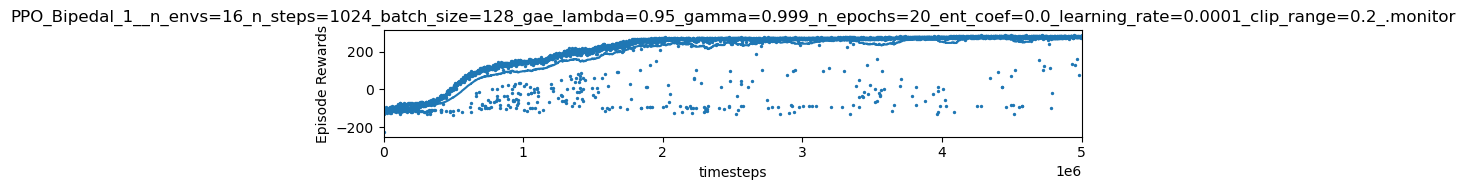

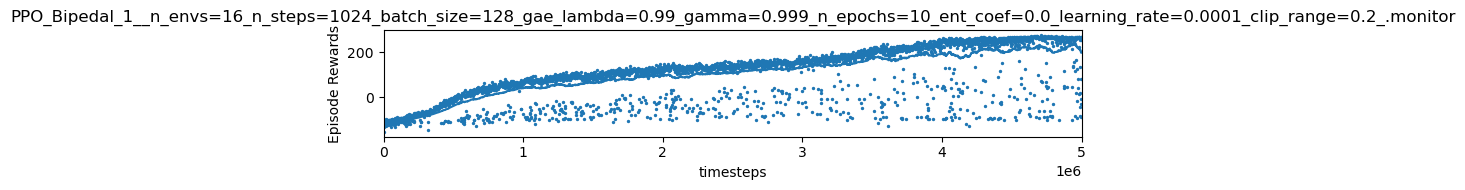

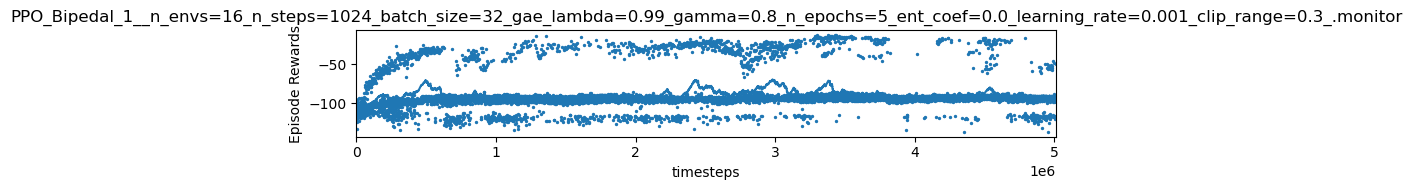

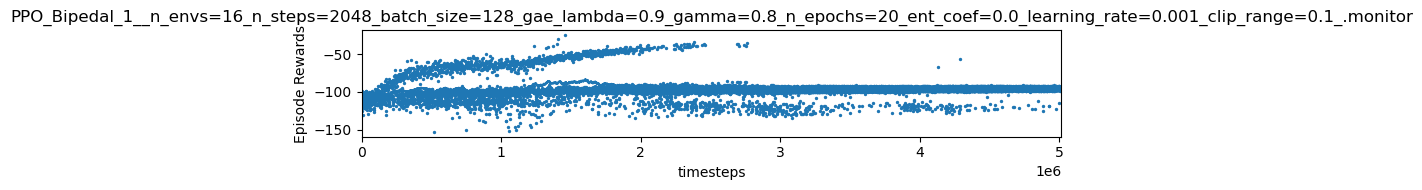

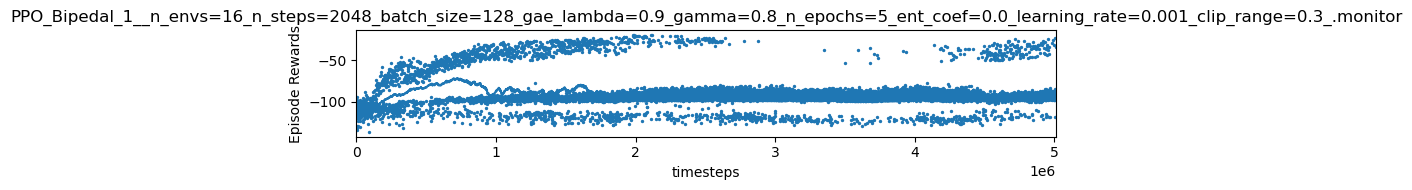

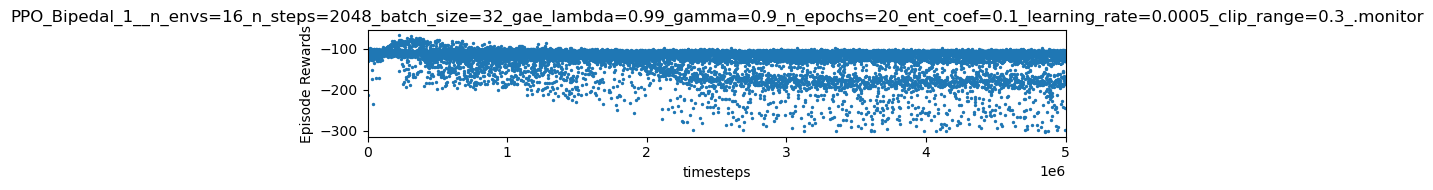

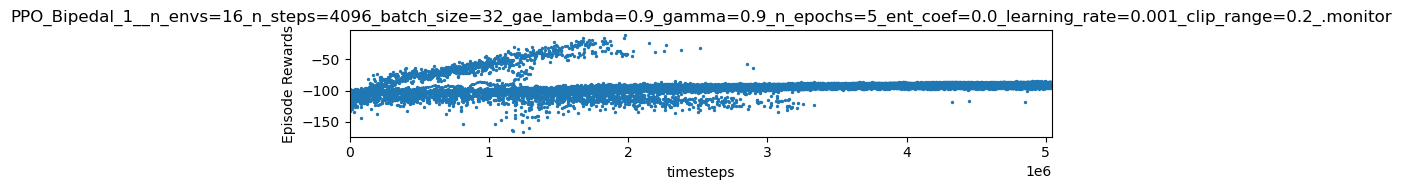

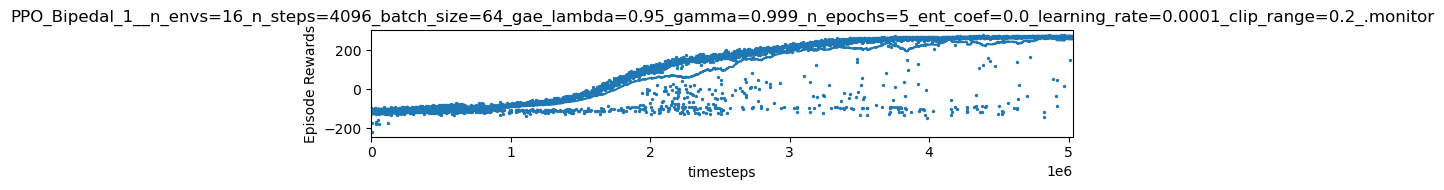

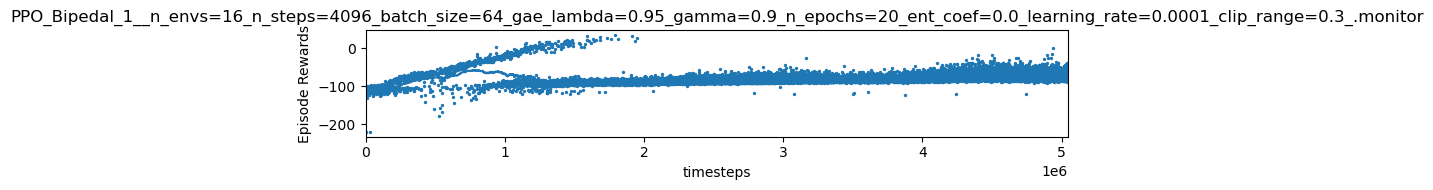

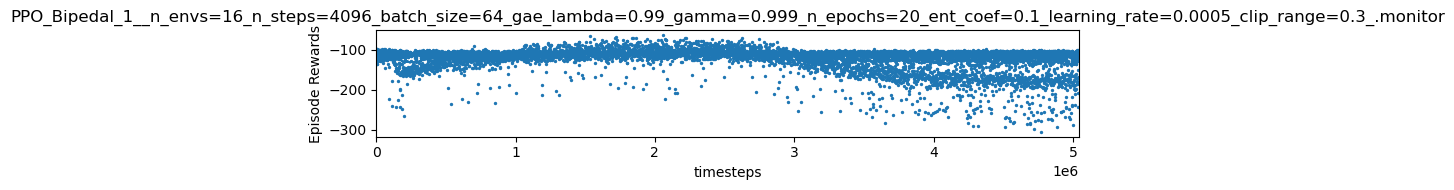

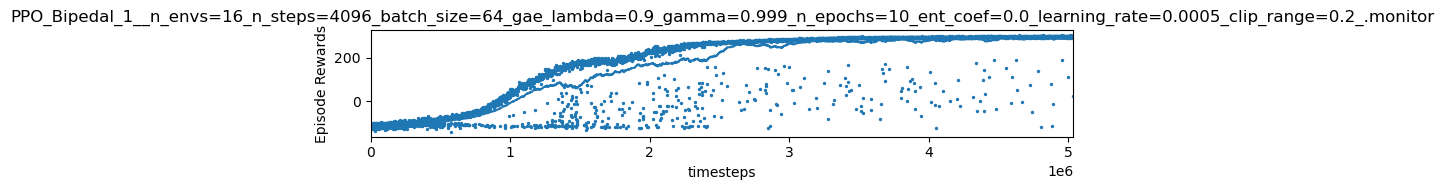

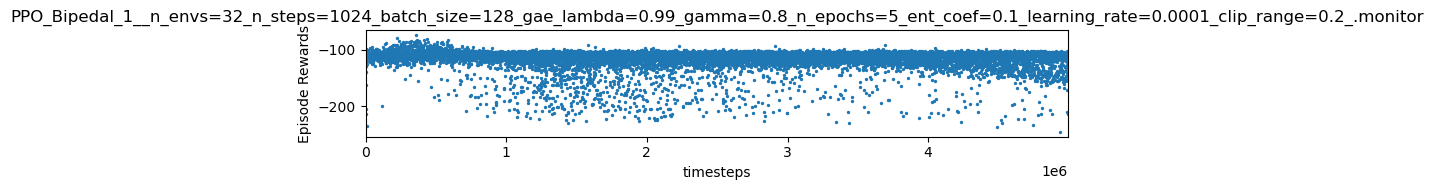

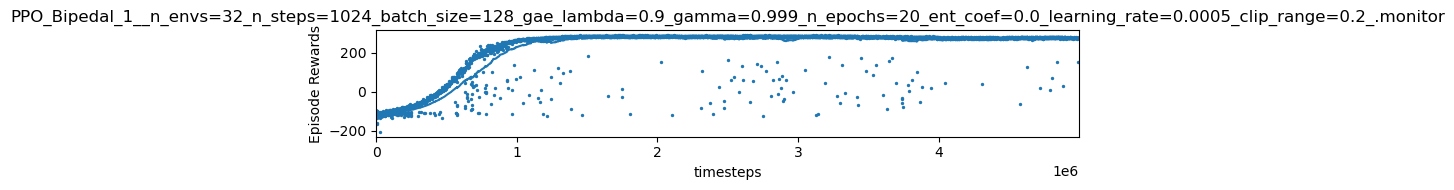

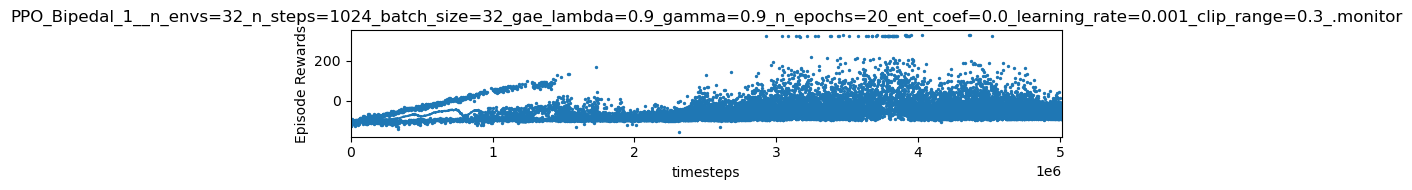

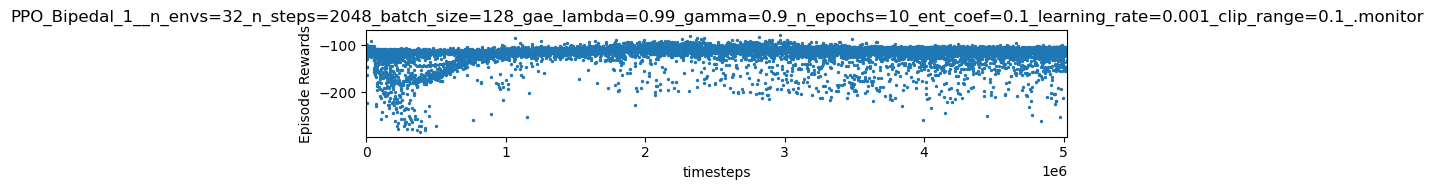

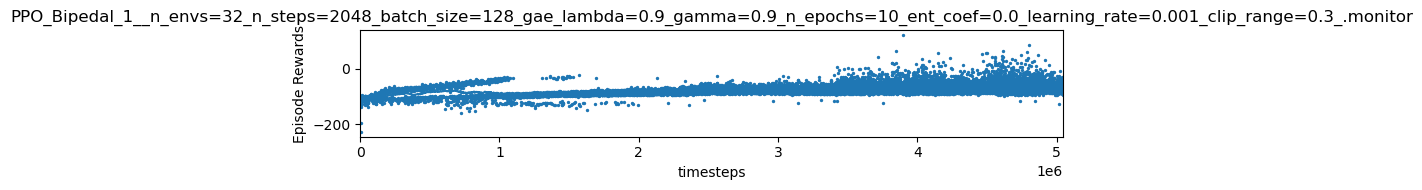

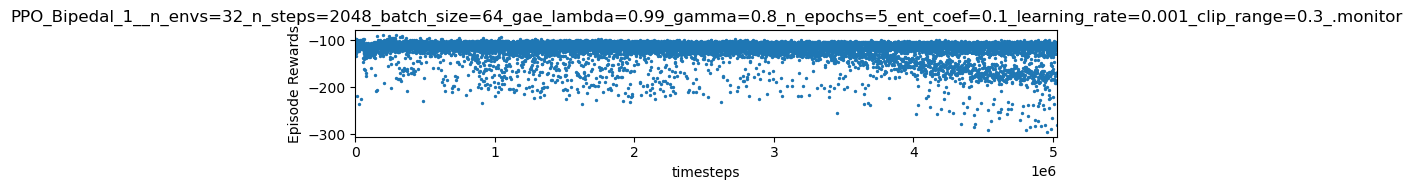

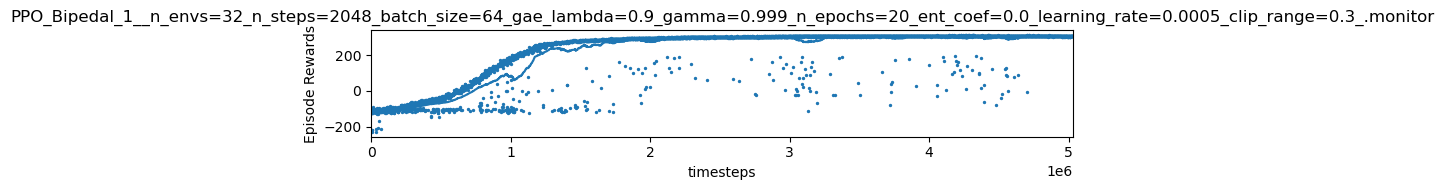

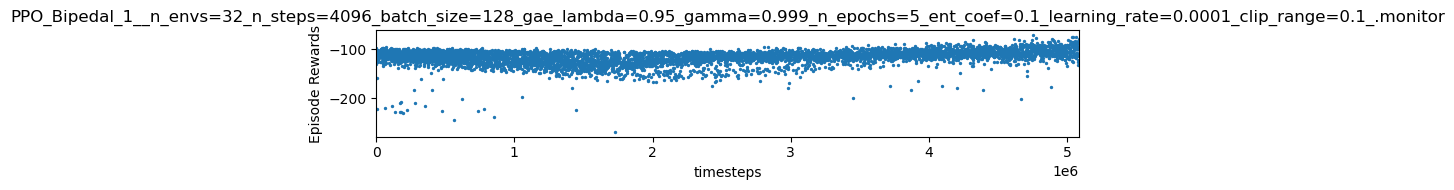

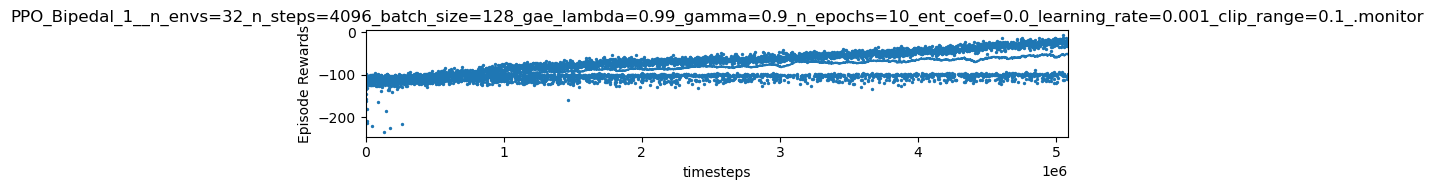

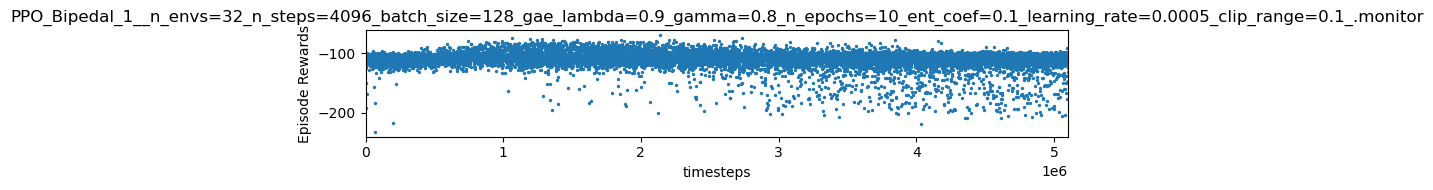

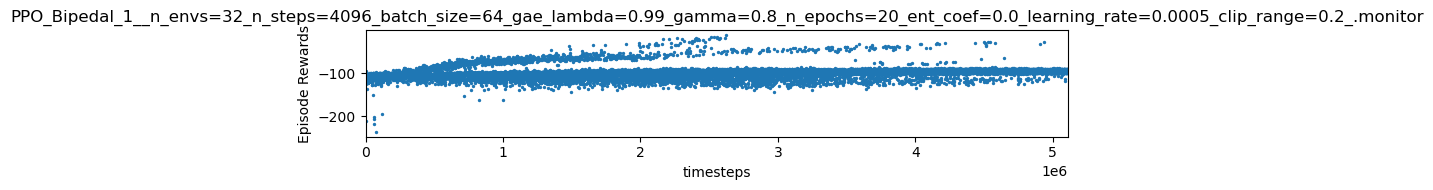

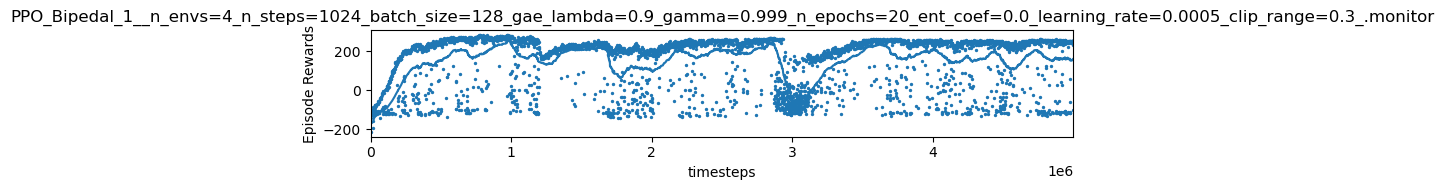

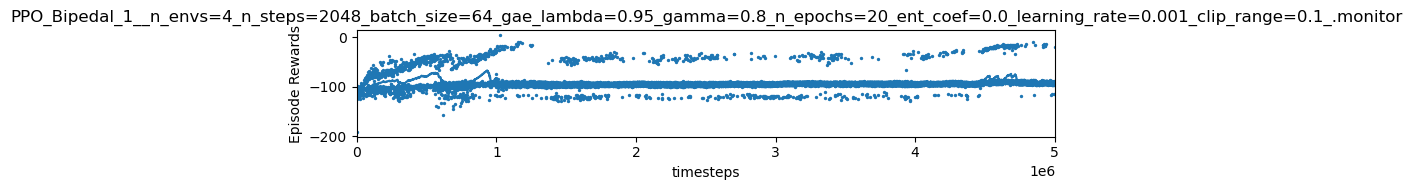

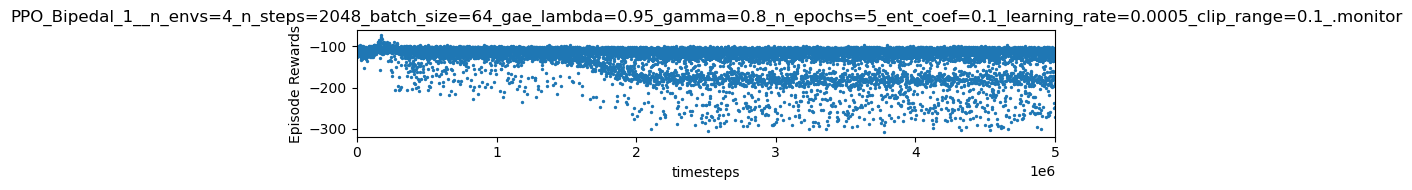

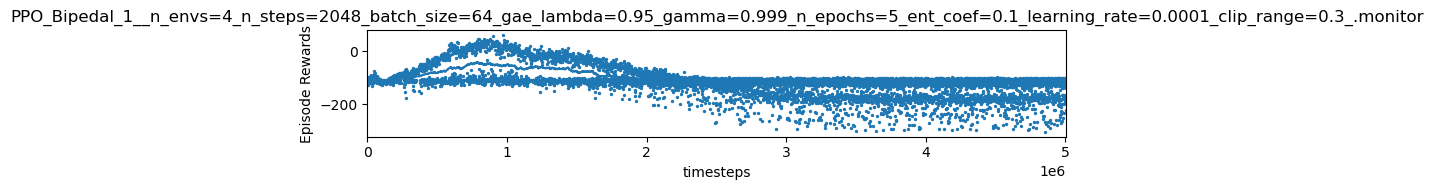

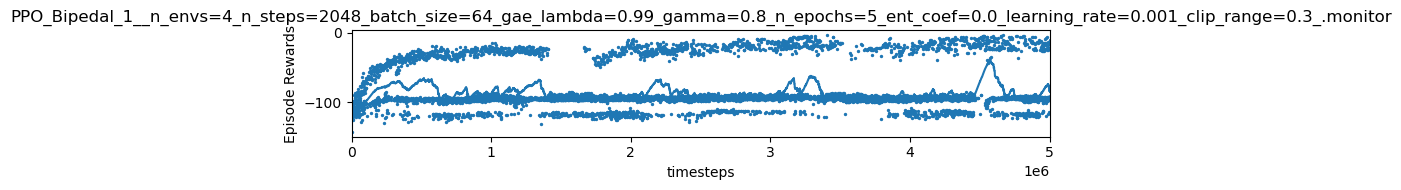

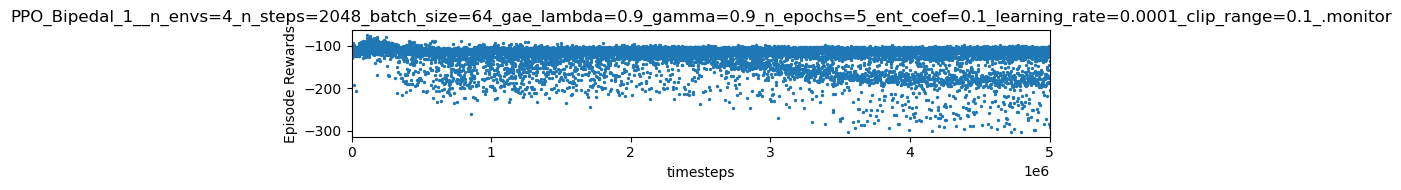

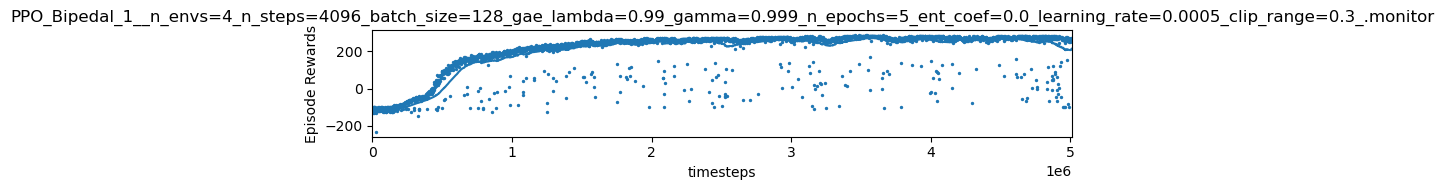

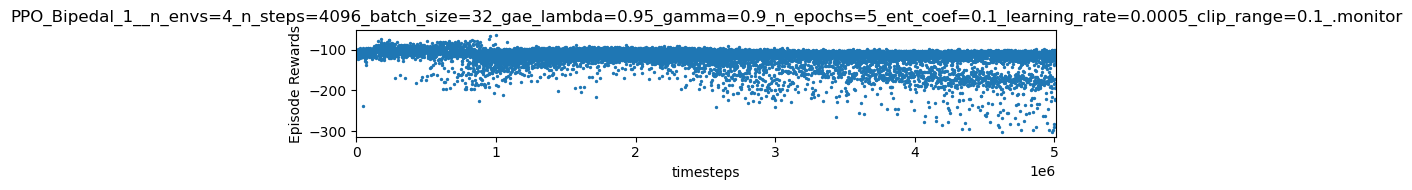

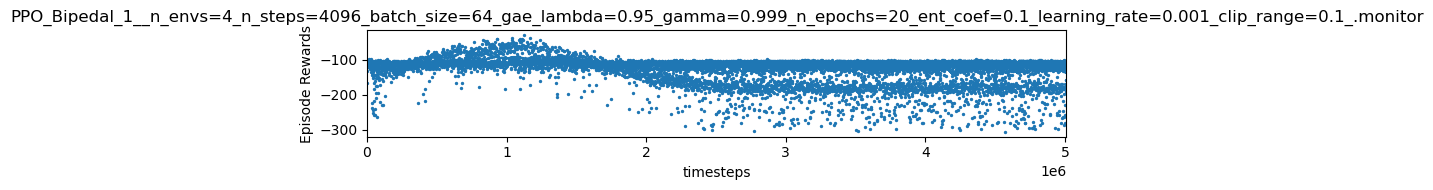

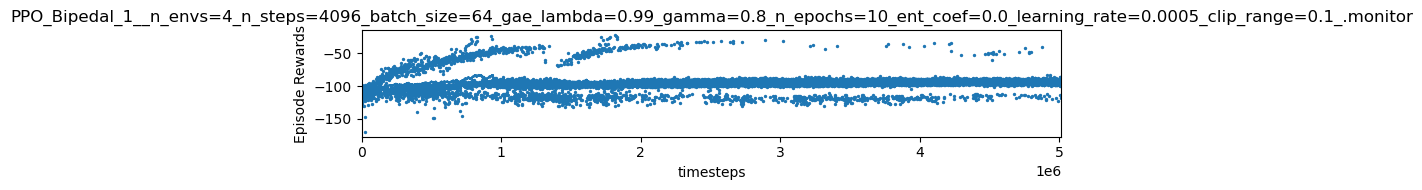

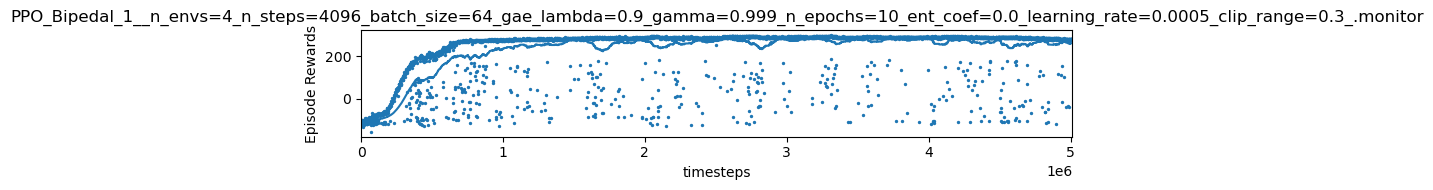

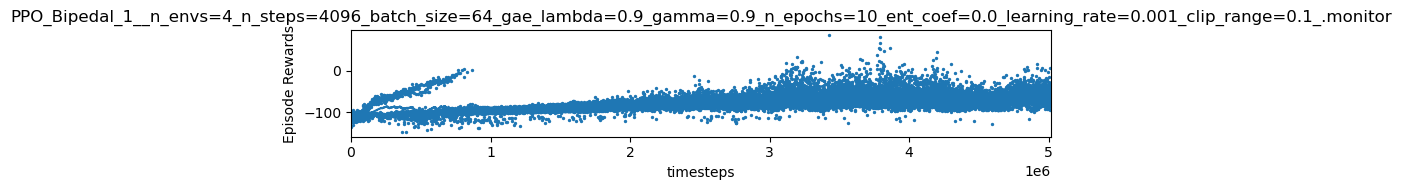

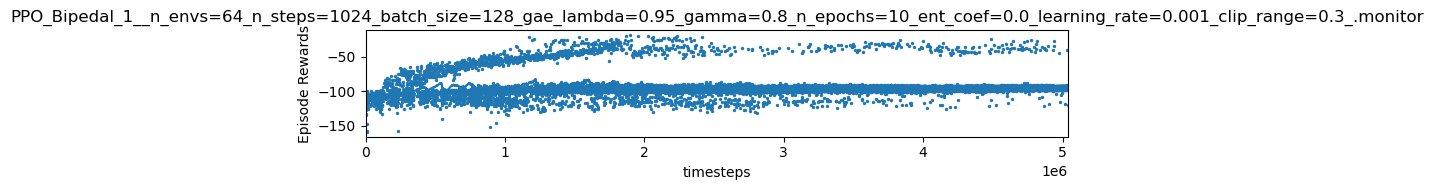

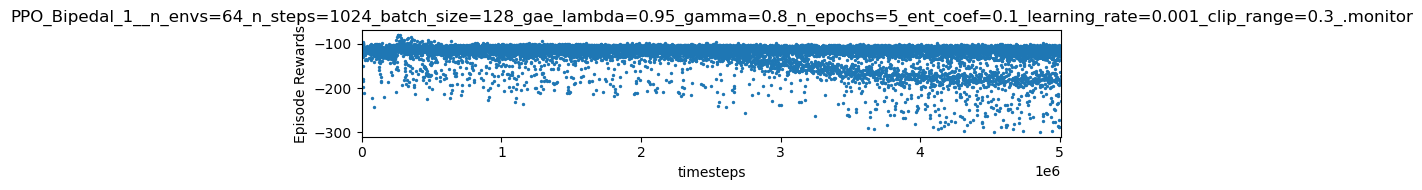

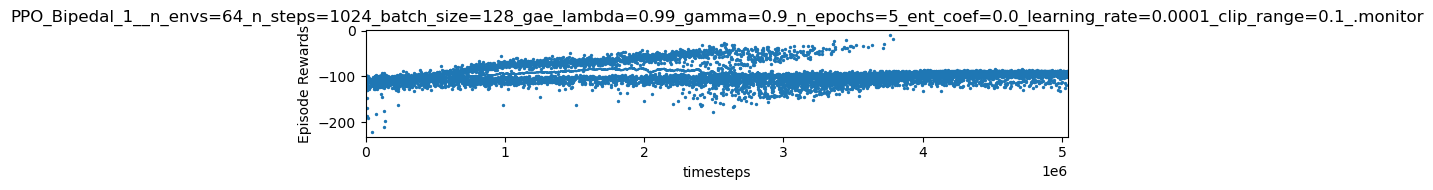

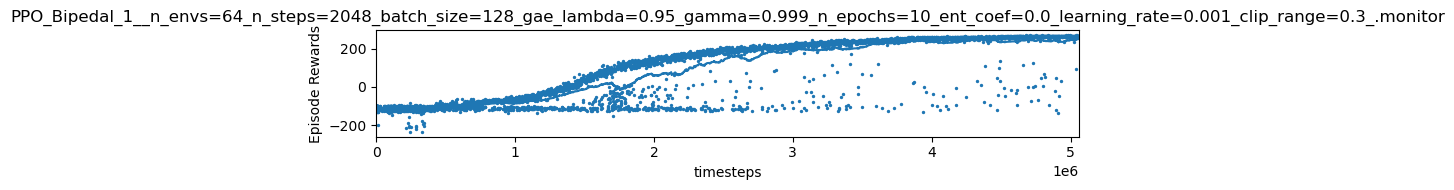

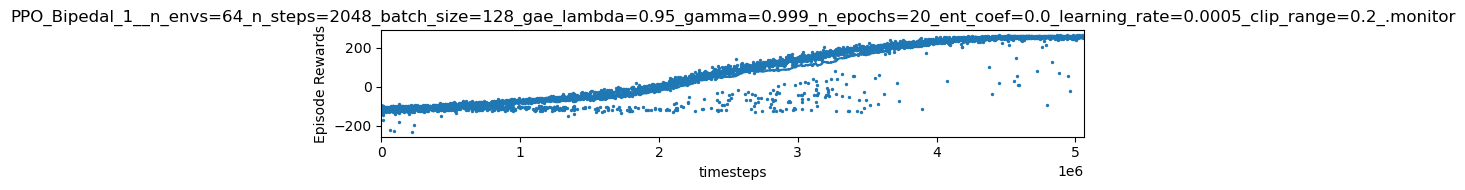

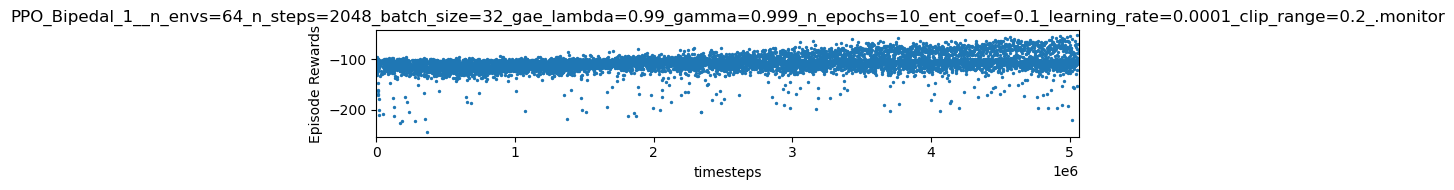

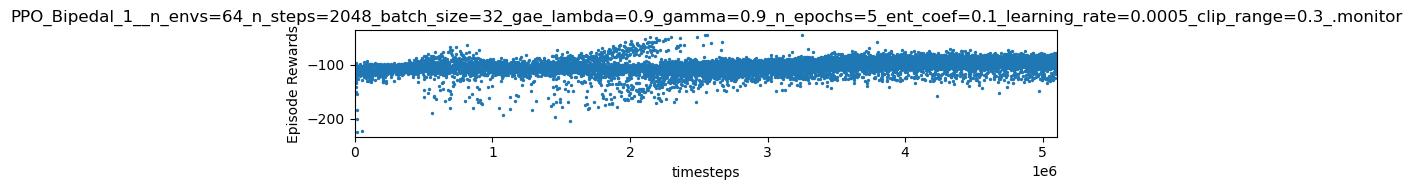

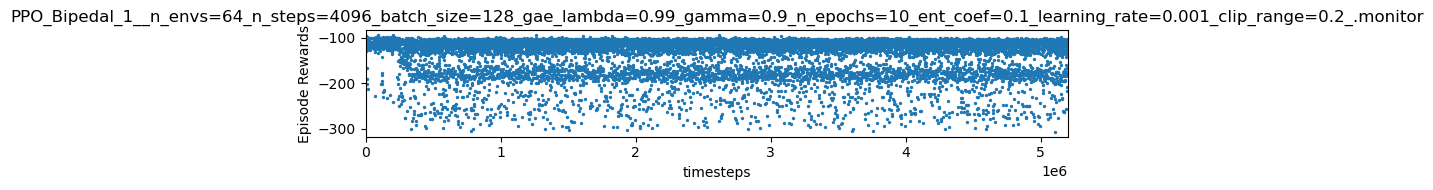

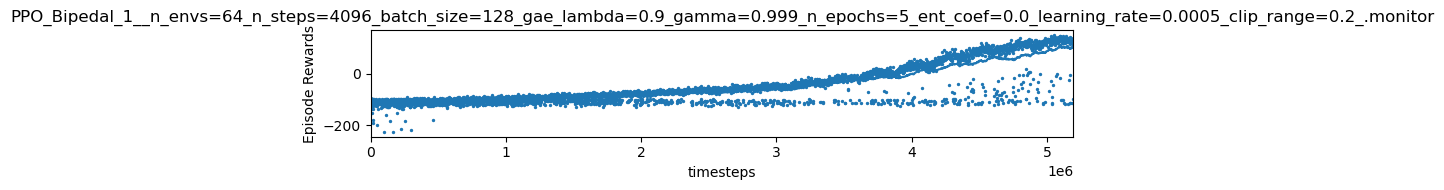

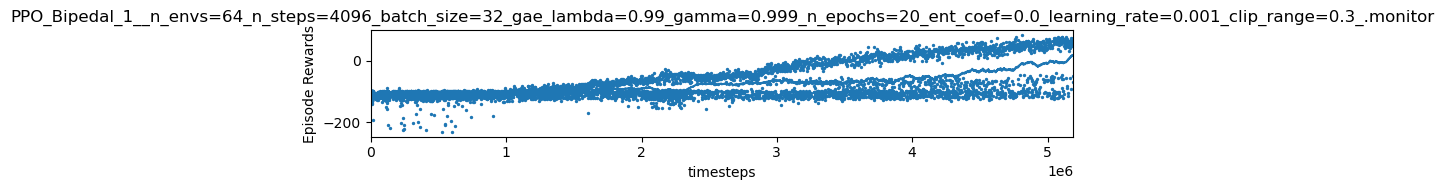

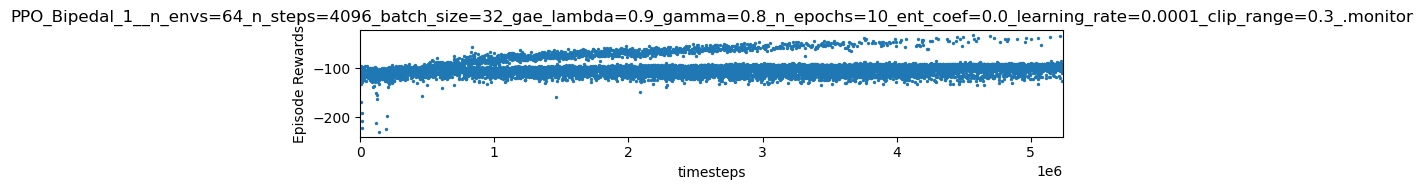

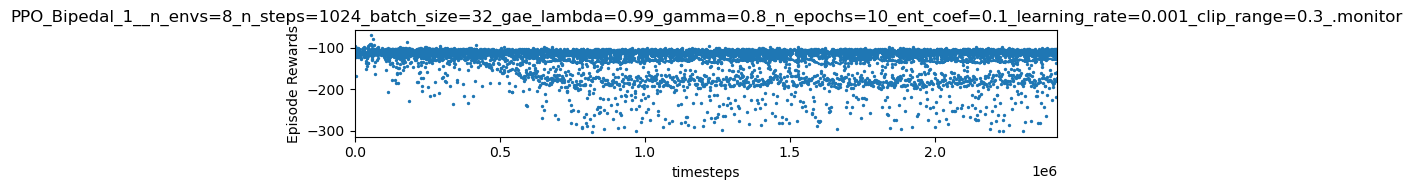

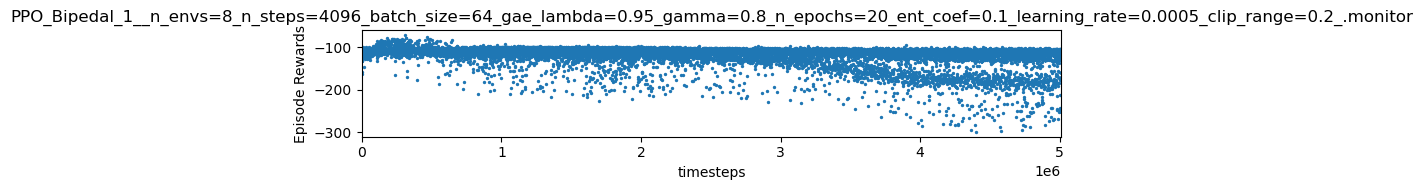

In [3]:
import matplotlib.pyplot as plt
import os

for folderName in os.listdir(log_dir)[1:]:
    folderPath = os.path.join(log_dir, folderName)
    results_plotter.plot_results(
        [folderPath], None, results_plotter.X_TIMESTEPS, folderName
    )
    plt.show()